In [1]:
%load_ext autoreload
%autoreload 2

# Introduction of Plotly Plasma
In this notebook we demonstrate the use of the `plotly plasma` library to circunvent many of the shortcomings of the standard Plotly library. 




Most of `plasma` functions can be called using figures.

> `plasma.function(figure)`

But you can also execute `plasma.fluent()` to add the `plasma` functions to the `plotly` library to keep using the [fluent interface](https://en.wikipedia.org/wiki/Fluent_interface), which will then allow you to do:

> `figure.function()`

This notebook will make use of the fluent syntax.

In [2]:
import pandas as pd
from plasma import plasma
import plotly.express as px
import plotly.io as pio
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pio.renderers.default = "svg"
pio.templates.default = "plotly_white"
plasma.fluent()

fix_marker_text, continuous_color and fix_facet_yaxes are now available on go.Figure


Lets first generate a dataset to work with

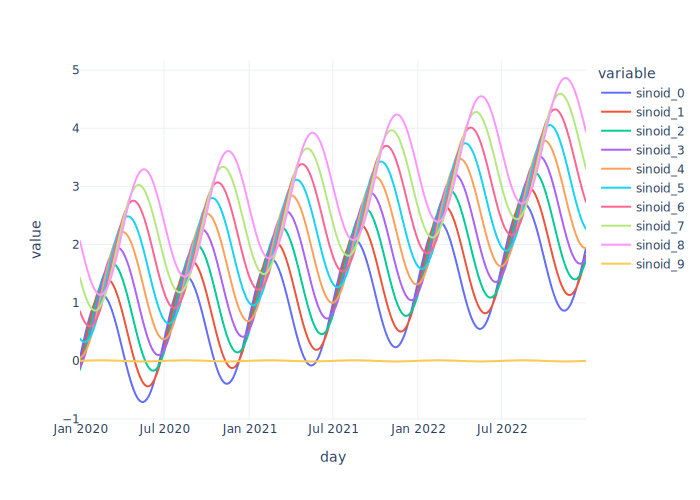

In [3]:
df_index = pd.date_range("2020-01-01", "2022-12-31", freq="D", name="day")
n_samples = df_index.shape[0]
x_array = np.linspace(-np.pi * 6, np.pi * 6, n_samples)
noise = np.random.random(df_index.shape[0])


def sinoid(x_lag, y_multiplier, linear_coefficient):
    return np.sin(x_array - x_lag) * y_multiplier + linear_coefficient


y_arrays = [
    sinoid(x_lag, y_multiplier, linear_coefficient) + x_array/20
    for x_lag, y_multiplier, linear_coefficient in zip(
        np.linspace(0, np.pi, 9), [1] * 9, np.linspace(1, 3, 9)
    )
]
y_arrays.append(sinoid(0, 0.01, 0))
data = pd.DataFrame(y_arrays).T.set_index(df_index)
data.columns = [f"sinoid_{i}" for i in range(10)]

px.line(data)


# Multiple y-axis
When the values of the metrics are in very different scales, plotly doesnt have an easy way to produce dual axis.

The default function will use the largest axis, and small variances will be barely noticeable.

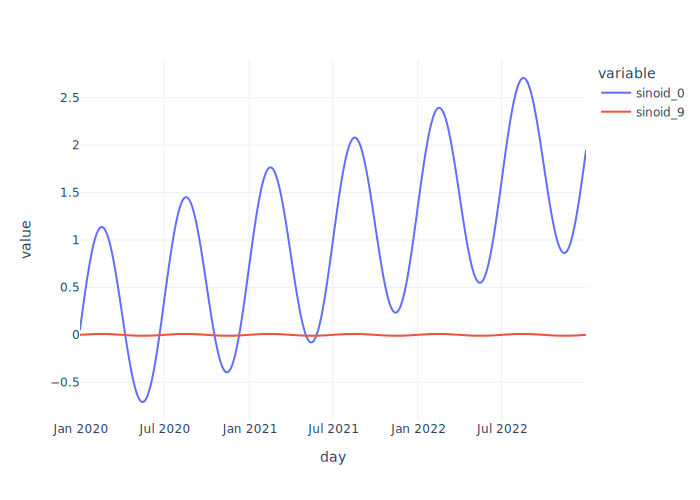

In [4]:
px.line(data[["sinoid_0", "sinoid_9"]])


## Dual axis with plotly

The workaround is to use subplots with `secondary_y`

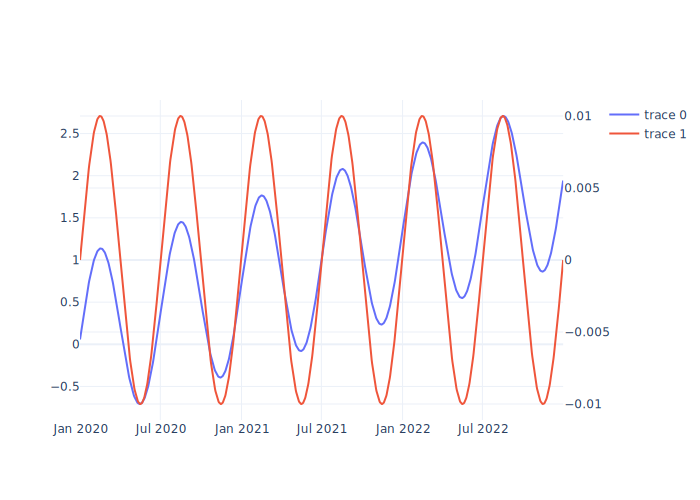

In [5]:
subplot_figure = make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])

subplot_figure = subplot_figure.add_trace(
    go.Scatter(x=data.index, y=data.sinoid_0), secondary_y=False
)

subplot_figure = subplot_figure.add_trace(
    go.Scatter(x=data.index, y=data.sinoid_9), secondary_y=True
)
subplot_figure


## Dual Axis with Plasma

`plasma` wraps that around the `dual_axis` method

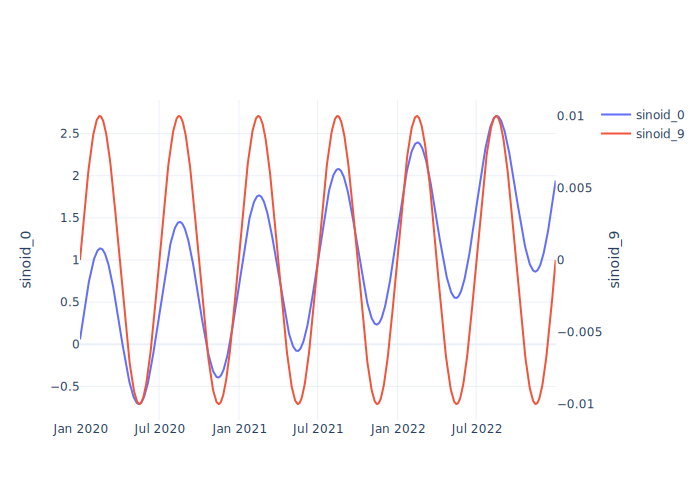

In [6]:
plasma.dual_axis_line(data, left_axis="sinoid_0", right_axis="sinoid_9")


# Markers
Default labels in Plotly can be very awkward

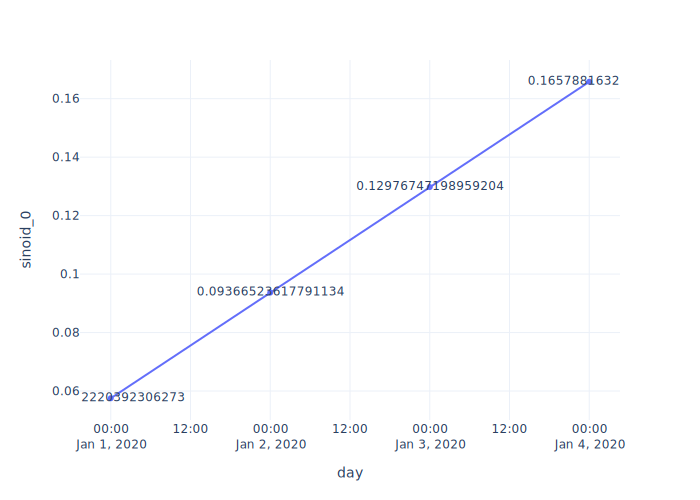

In [7]:
fig = px.line(
    data.loc[:"2020-01-04"],
    y="sinoid_0",
    text="sinoid_0",
)
fig


## Plotly markers text
The default solution to that problem is somewhat clumsy.

The argument names are not very intuitive, and the `tickformat` format string does not follow the same format as `texttemplate`

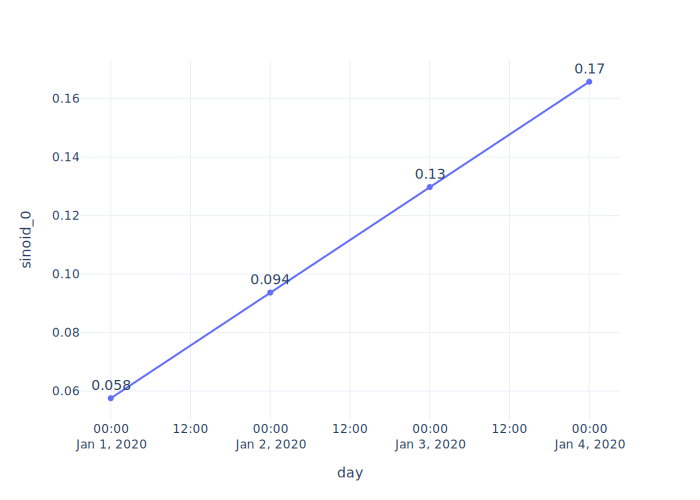

In [8]:
fig.update_traces(
    texttemplate="%{text:.2}",
    textfont=go.scatter.Textfont(size=14),  # could also be just {"size": 14},
    textposition="top center",
).update_yaxes(tickformat=".2f")


# Markers text with Plasma
`plasma` will round floating numbers to one decimal by default.

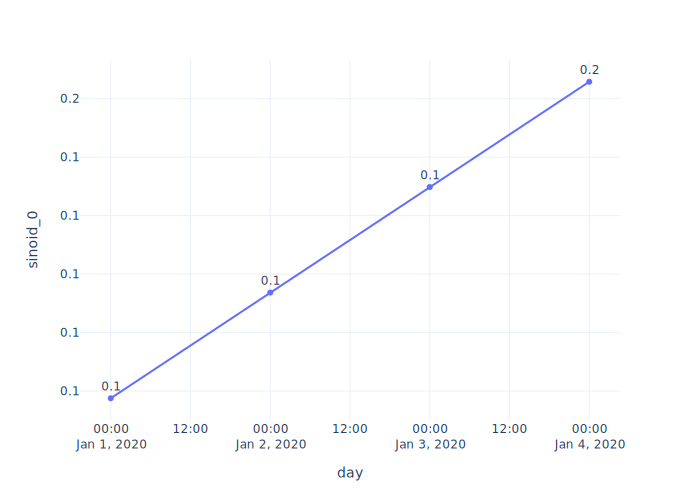

In [9]:
fig.fix_marker_text()

You can also use python standard format strings for markers and tick format.
In this example, we use that feature to format the numbers as percentages.

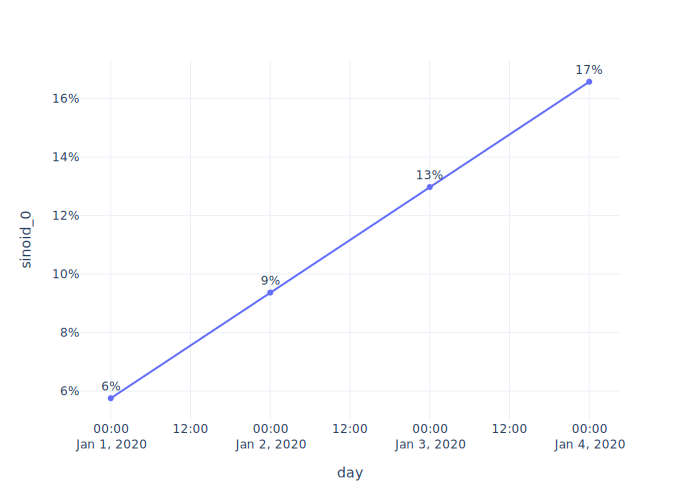

In [10]:
fig.fix_marker_text(marker_format="{:.0%}", tick_format="{:.0%}")


# Year-over-year comparisons
Lets try to overlay the data from different years

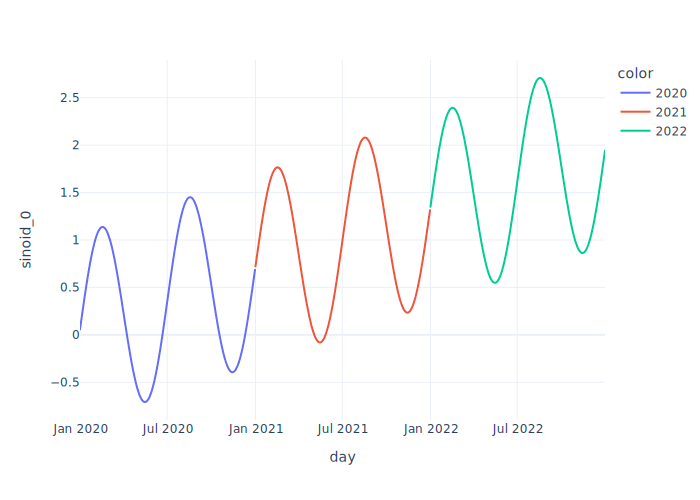

In [11]:
px.line(data, y="sinoid_0", color=data.index.year)


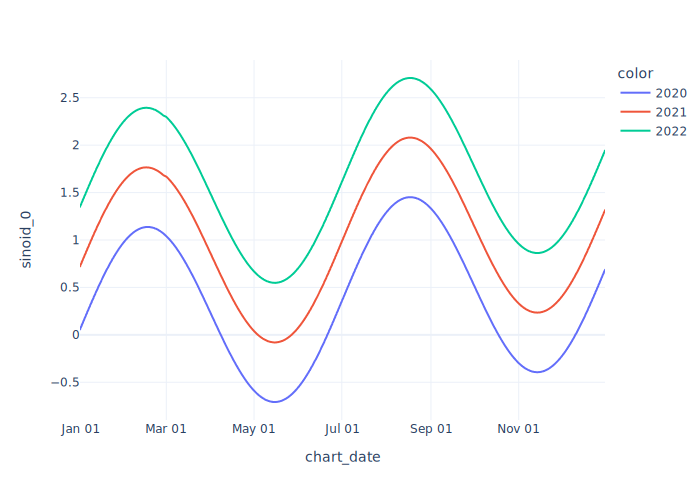

In [12]:
overlayed = data.assign(chart_date=lambda df: df.index.strftime("2020-%m-%d"))
px.line(overlayed, x="chart_date", y="sinoid_0", color=data.index.year).update_xaxes(
    tickformat="%b %d"
)



You can use `plasma.overlay_yoy` to achieve the same effect, but passing a DataFrame instead, as long as the date is the index.

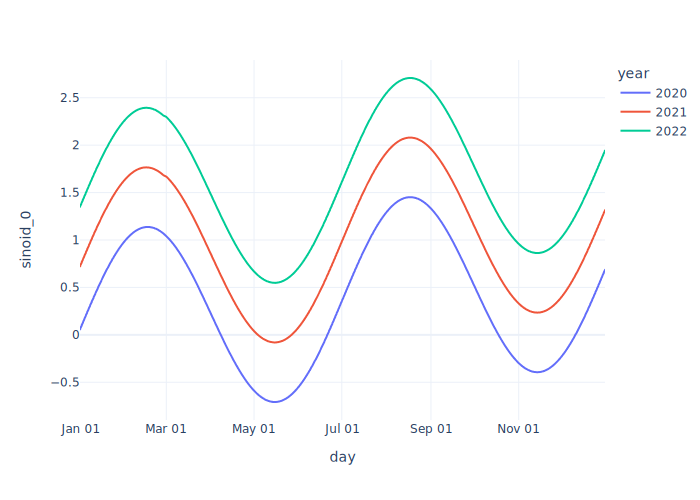

In [13]:
data.pipe(plasma.overlay_yoy, "sinoid_0")


# Multiple lines as continuous color
When you have multiple lines, plotly has no easy way to color them using a variable like a continuous measure.
By default, Plotly will use it as a discrete variable.

In [14]:
tall_format = data.reset_index().melt(id_vars='day')
tall_format.head()


,day,variable,value
0,2020-01-01,sinoid_0,0.057522
1,2020-01-02,sinoid_0,0.093665
2,2020-01-03,sinoid_0,0.129767
3,2020-01-04,sinoid_0,0.165788
4,2020-01-05,sinoid_0,0.201687


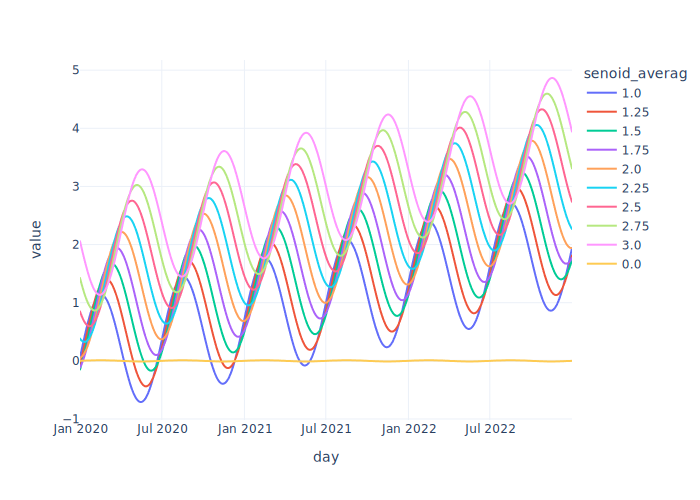

In [15]:
tall_format["senoid_average"] = (
    tall_format.groupby("variable")["value"].transform("mean").round(2)
)
fig = px.line(tall_format, x="day", y="value", color="senoid_average")
fig


The workaround is to change manually the color attribute of the traces.

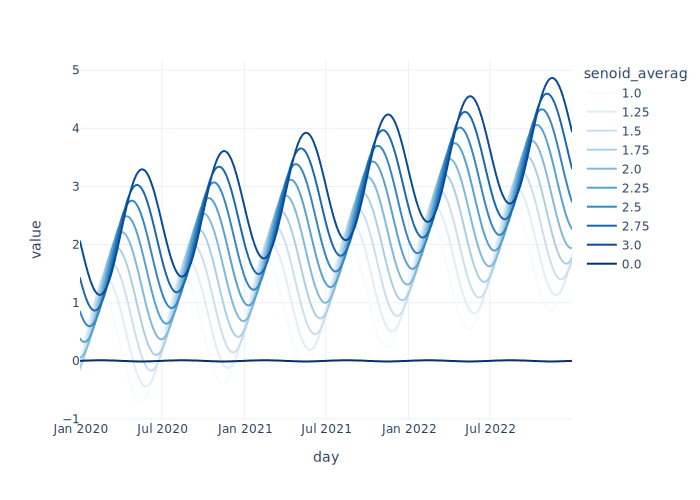

In [16]:
n_colors = 10
colors = px.colors.sample_colorscale("Blues", n_colors)
for index, color in enumerate(colors):
    fig.data[index]["line"]["color"] = color
fig


Thats wrapped in `plasma.continuous_color`

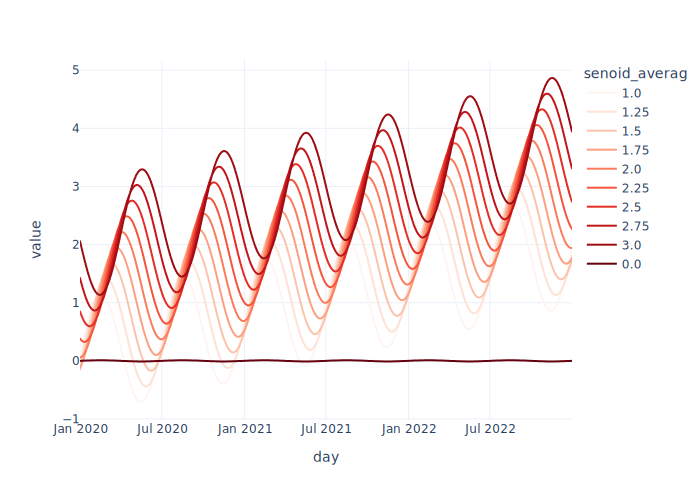

In [17]:
fig.continuous_color(colorscale="Reds")


# Facets
Default facets have a terrible `column_name=column_value` labels for y-axis, and they also share the same scale.
Let reshape our data and increase the length the names of the fields.

In [18]:
tall_format = (
    data[["sinoid_0", "sinoid_8", "sinoid_9"]].reset_index().melt(id_vars="day")
).assign(variable = lambda df: 'column_' + df.variable)
tall_format.head()


,day,variable,value
0,2020-01-01,column_sinoid_0,0.057522
1,2020-01-02,column_sinoid_0,0.093665
2,2020-01-03,column_sinoid_0,0.129767
3,2020-01-04,column_sinoid_0,0.165788
4,2020-01-05,column_sinoid_0,0.201687


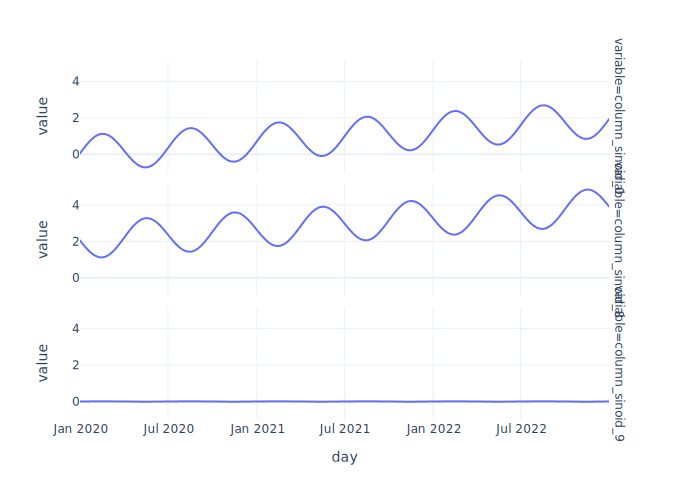

In [19]:
fig = px.line(tall_format, x="day", y="value", facet_row="variable")
fig


We can fix them using `update_yaxes(matches=None)` and `for_each_annotation`.

If the labels are still too long, you can try `font_size` 

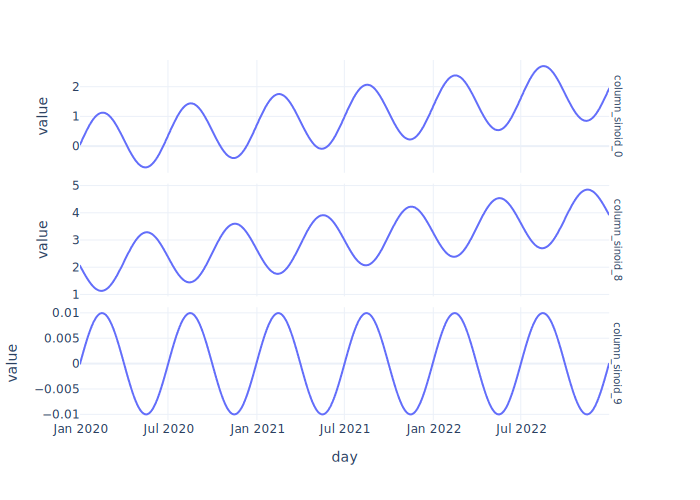

In [20]:
fig.update_yaxes(matches=None).for_each_annotation(
    lambda annotation: annotation.update(
        text=annotation.text.split("=")[1], font_size=10
    )
)

fig


Which we wrap in `plasma.fix_facet_yaxes`

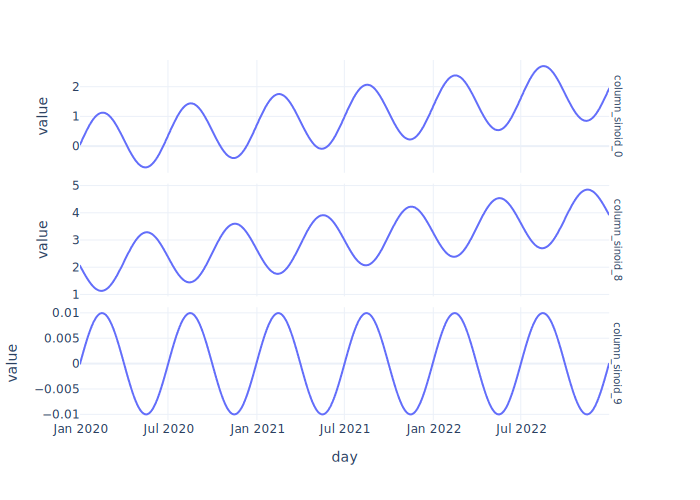

In [21]:
px.line(tall_format, x="day", y="value", facet_row="variable").fix_facet_yaxes(
    font_size=10
)
